## Introduction

This week, we worked on two models: **Random Forest** and **XGBoost**. Both are based on decision trees but work in different ways.

- **Random Forest** builds many trees at once (parallel) and takes the average of their results to make predictions. This helps reduce overfitting.
- **XGBoost** builds trees one after another (sequential), where each tree tries to fix the mistakes made by the previous ones. This helps improve accuracy.

The goal is to train both models on the same dataset, check their performance, and compare them using different evaluation methods.

## Project Workflow

**Step 1: Data Preparation**  
- Load the dataset.  
- Select features (X) and target variable (y).  
- Split the data into training and testing sets.  
- Apply scaling if needed (mostly for boosting).

**Step 2: Baseline with Decision Tree**  
- Before trying ensemble methods, a simple `DecisionTreeRegressor` was trained.  
- This helped in understanding the base performance of a single tree.  
- The results from this model serve as a reference to compare with Random Forest and XGBoost.

**Step 3: Random Forest Model**  
- Train a `RandomForestRegressor` on the training data.  
- Try different values for hyperparameters like number of trees, max depth, etc.  
- Check the performance using metrics like MSE and R².  
- Plot residuals and predicted vs actual values.

**Step 4: XGBoost Model**  
- Train a `XGBRegressor` on the same training data.  
- Tune hyperparameters like learning rate, max depth, number of estimators, etc.  
- Again, evaluate using the same metrics for fair comparison.

**Step 5: Comparing Models**  
- Compare all models using:  
  - Mean Squared Error (MSE)  
  - R² Score  
  - Residual plots  
  - Feature importance  
  - Speed and performance

**Step 6: Visualization**  
- Plot feature importance  
- Actual vs Predicted values  
- Residuals  
- Error distribution

## Why This Project

In real-world problems, single models often don’t perform well.  
Ensemble methods like Random Forest and XGBoost help improve performance.  
This project helps understand how both models work and which one fits better for the dataset.


# **Study of Dataset**

Before applying any models, we first study and explore the dataset to understand its structure, relationships between variables, and data quality.

### Step 1: Importing Libraries  
We import necessary Python libraries such as:
- `pandas` and `numpy` for data handling
- `matplotlib` and `seaborn` for visualization
- `sklearn` tools for data splitting, evaluation, and warnings suppression

### Step 2: Loading and Viewing Dataset  
We load the dataset `Income2.csv` using `pandas.read_csv()`.  
We check:
- Column names using `income.columns`
- Dataset shape (rows, columns)
- First 5 records using `income.head()`

We also drop the column `'Unnamed: 0'` which was not useful (usually comes from index column during CSV export).

### Step 3: Correlation Analysis  
To understand how different features relate with the target variable `Income`, we:
- Compute the correlation matrix using `income.corr()`
- Plot the correlation heatmap using `seaborn.heatmap()` to visualize relationships between features

We also extract and print the sorted correlation of all features with `Income` to identify the most relevant predictors.

### Step 4: Scatter Plot Analysis  
To analyze how individual features affect Income, we create scatter plots for:
- `Education vs Income`
- `Seniority vs Income`

These plots help visualize trends, clusters, and outliers in feature-target relationships.

### Step 5: Summary Statistics  
We use `income.describe()` to generate summary statistics like mean, standard deviation, min, max, and quartiles for each numerical feature. This helps in understanding data distribution and detecting any potential anomalies.

---

This step is essential as it guides feature selection and model choice. The plots and correlation insights help us decide which features might be more useful for prediction tasks.


Index(['Unnamed: 0', 'Education', 'Seniority', 'Income'], dtype='object')
(30, 4)


   Unnamed: 0  Education   Seniority     Income
0           1  21.586207  113.103448  99.917173
1           2  18.275862  119.310345  92.579135
2           3  12.068966  100.689655  34.678727
3           4  17.034483  187.586207  78.702806
4           5  19.931034   20.000000  68.009922
Income       1.000000
Education    0.901003
Seniority    0.518288
Name: Income, dtype: float64


,Education,Seniority,Income
count,30.000000,30.000000,30.000000
mean,16.386207,93.862069,62.744733
std,3.810622,55.715623,27.013285
min,10.000000,20.000000,17.613593
25%,12.482759,44.827586,36.392043
50%,17.034483,94.482759,70.804791
75%,19.931034,133.275862,85.930608
max,21.586207,187.586207,99.917173


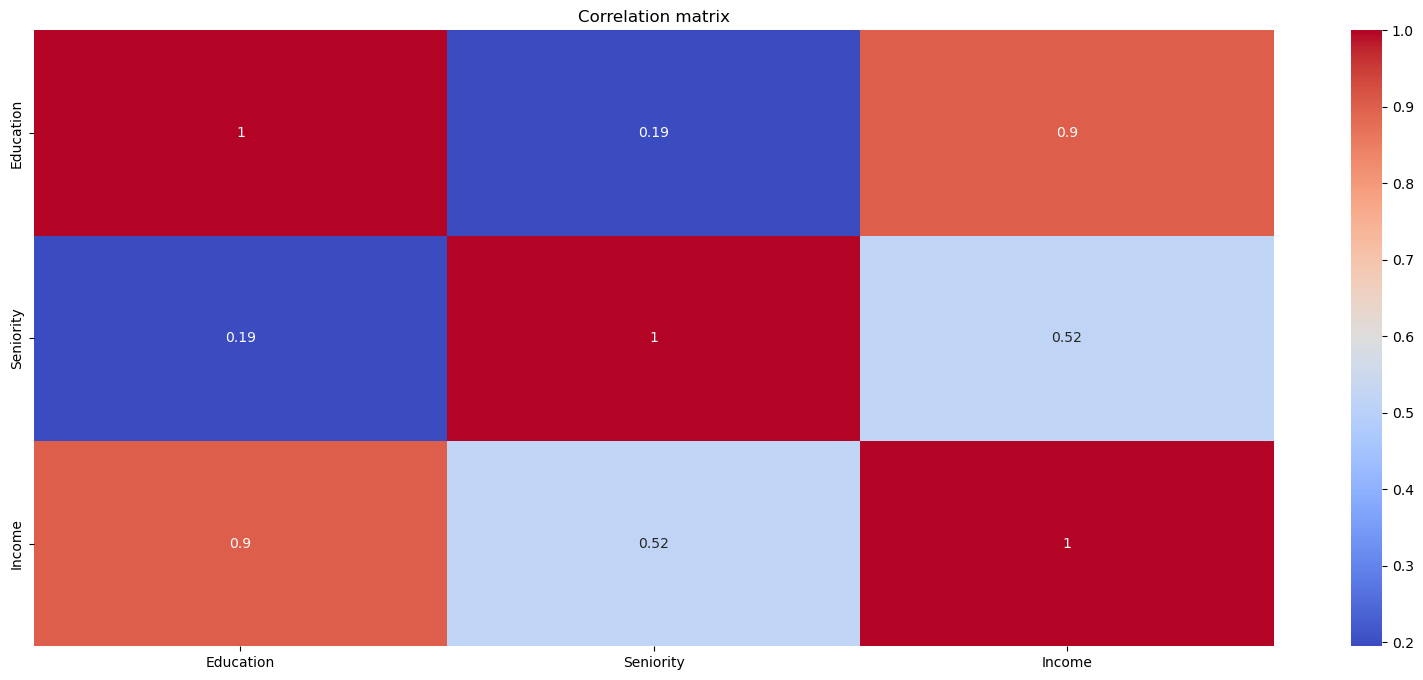

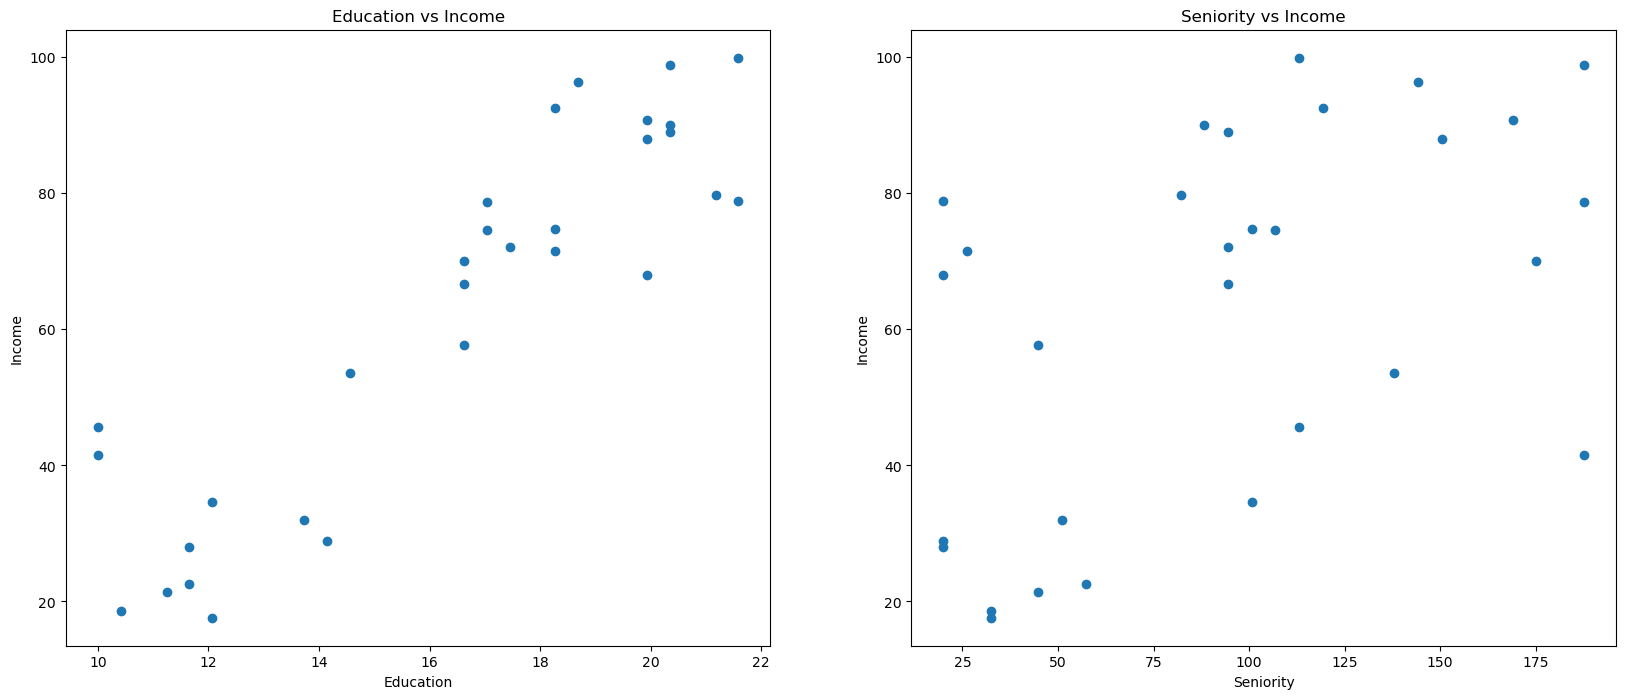

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import subplots
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import random
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


income = pd.read_csv('Income2.csv')
print(income.columns)


print(income.shape)
print("\n")
#Looking for description of dataset
print(income.head(5))

income = income.drop('Unnamed: 0', axis=1)
# Correlation matrix is:

cor_rel = income.corr()
k,l = subplots(figsize = (20,8))
sns.heatmap(cor_rel, annot= True, cmap='coolwarm' )
l.set_title('Correlation matrix')

cor = cor_rel['Income'].sort_values(ascending= False)
print(cor)

#ploting the correlation graph between income vs education and income vs seniority
ax, f = subplots(1,2, figsize = (20,8))
f[0].scatter(income['Education'], income['Income'], colorizer='r')
f[0].set_xlabel('Education')
f[0].set_ylabel('Income')
f[0].set_title('Education vs Income')
f[0].plot()

f[1].scatter(income['Seniority'], income['Income'], colorizer='r')
f[1].set_xlabel('Seniority')
f[1].set_ylabel('Income')
f[1].set_title('Seniority vs Income')
f[1].plot()

income.describe()


## **Decision Tree Regression**

Before jumping into ensemble methods like Random Forest and XGBoost, we implemented a custom Decision Tree Regression model from scratch. This helped us understand the basic tree-building process and its inner workings like splits, pruning, and predictions.

### Step 1: Recursive Binary Splitting
We use a function called `rec_binary_split()` to recursively divide the dataset into two regions based on the best feature and threshold. The split is chosen to minimize the **Residual Sum of Squares (RSS)**:
- All possible midpoints of feature values are considered
- For each split, the RSS is calculated for left and right regions
- The feature and split point that result in the lowest combined RSS is selected

### Step 2: Tree Construction
We construct the decision tree using `build_tree()`, which recursively applies the splitting logic:
- If max depth is reached or too few samples remain, a **leaf node** is created with the mean target value.
- Otherwise, we store the best feature, threshold, and recursively build left and right subtrees.

### Step 3: Cost-Complexity Pruning
To prevent overfitting, we prune the tree using a method inspired by cost-complexity pruning:
- For each subtree, we compare the RSS of the subtree with that of converting the subtree into a leaf.
- The decision depends on a regularization parameter **alpha**.
- A lower alpha means we allow more complex trees; a higher alpha leads to more aggressive pruning.
We use cross-validation (`select_best_alpha_by_cv()`) to choose the best alpha by comparing validation RSS across folds for different alpha values.

### Step 4: Final Pruned Tree
After selecting the best alpha, we prune the original tree to get the **final best subtree** using `get_best_subtree()`.

### Step 5: Prediction using Tree
Prediction is done using `predict_tree()`:
- For each input point, we traverse the tree from root to leaf, comparing feature values with thresholds at each node.
- The predicted value is the value of the reached leaf node.

### Step 6: Evaluation Metrics
We compute several metrics:
- **Training MSE** using `training_mse()`
- **R² Score** using a custom `r2_score_custom()` function
- **RSS of the final pruned tree** using `calculate_rss()`

### Step 7: Visualizations
We also plot:
- RSS vs Alpha curve to visualize effect of pruning strength
- Actual vs Predicted plot for both train and test data
- Residual plot to check patterns in errors
- Histogram of residuals to understand distribution
- Prediction line (only if the data has 1 feature)

---

This Decision Tree implementation gave us full control and visibility over how splits, predictions, and pruning work internally. It also sets a foundation for understanding ensemble models like Random Forest and XGBoost, which we'll explore next.


In [2]:

#  RSS function
def rss(y, y_pred):
    return np.sum((y - y_pred) ** 2)

#  Midpoint split generation
def s_for_x(x):
    s = []
    unique_vals = np.sort(np.unique(x))
    for i in range(len(unique_vals) - 1):
        midpoint = (unique_vals[i] + unique_vals[i + 1]) / 2
        s.append(midpoint)
    return s

#  Recursive Binary Split
def rec_binary_split(x, y, x_full):
    s_xj = []
    rss_xj = []

    for j in range(x.shape[1]):
        xj = x[:, j]
        rss_er = []
        s = s_for_x(xj)

        for i in s:
            R1 = xj < i
            R2 = xj >= i

            if np.sum(R1) == 0 or np.sum(R2) == 0:
                continue  # skip invalid split

            y_left = y[R1]
            y_right = y[R2]

            rss_val = rss(y_left, np.mean(y_left)) + rss(y_right, np.mean(y_right))
            rss_er.append(rss_val)

        if len(rss_er) == 0:
            continue  # skip if all splits are invalid

        min_rss_indx = np.argmin(rss_er)
        min_rss = rss_er[min_rss_indx]
        threshold = s[min_rss_indx]

        s_xj.append(threshold)
        rss_xj.append(min_rss)

    if len(rss_xj) == 0:
        return 0, np.mean(x[:, 0]), x_full, x_full, y, y  # fallback split

    rss_xj_indx = np.argmin(rss_xj)
    s_best = s_xj[rss_xj_indx]
    best_feature_index = rss_xj_indx

    x_column = x_full[:, best_feature_index]
    x_full_R1 = x_full[x_column < s_best]
    x_full_R2 = x_full[x_column >= s_best]
    y_R1 = y[x_column < s_best]
    y_R2 = y[x_column >= s_best]

    return best_feature_index, s_best, x_full_R1, x_full_R2, y_R1, y_R2

#  Tree building
def build_tree(x, y, depth=0, max_depth=3):
    if depth >= max_depth or len(y) <= 1:
        return {'leaf_value': np.mean(y)}

    feature_index, threshold, x_left, x_right, y_left, y_right = rec_binary_split(x, y, x)

    left_subtree = build_tree(x_left, y_left, depth + 1, max_depth)
    right_subtree = build_tree(x_right, y_right, depth + 1, max_depth)

    return {
        'feature_index': feature_index,
        'threshold': threshold,
        'left': left_subtree,
        'right': right_subtree
    }

#  Tree visualization
def print_tree(tree, depth=0):
    indent = "  " * depth
    if 'leaf_value' in tree:
        print(f"{indent}Leaf: Predict {tree['leaf_value']:.4f}")
    else:
        feature = tree['feature_index']
        threshold = tree['threshold']
        print(f"{indent}Node: x[{feature}] < {threshold:.4f}")
        print(f"{indent} Left:")
        print_tree(tree['left'], depth + 1)
        print(f"{indent} Right:")
        print_tree(tree['right'], depth + 1)

#  Leaf check
def is_leaf(node):
    return 'leaf_value' in node

#  Leaf count
def count_leaves(tree):
    if is_leaf(tree):
        return 1
    return count_leaves(tree['left']) + count_leaves(tree['right'])

#  RSS calculation for whole tree
def calculate_rss(tree, x_true, y_true):
    if is_leaf(tree):
        return np.sum((y_true - tree['leaf_value']) ** 2)

    feature = tree['feature_index']
    threshold = tree['threshold']

    left_mask = x_true[:, feature] < threshold
    right_mask = x_true[:, feature] >= threshold

    return calculate_rss(tree['left'], x_true[left_mask], y_true[left_mask]) + \
           calculate_rss(tree['right'], x_true[right_mask], y_true[right_mask])

#  Pruning using cost-complexity
def cost_complexity_prune(tree, x_true, y_true, alpha):
    if is_leaf(tree):
        return tree

    feature = tree['feature_index']
    threshold = tree['threshold']

    left_mask = x_true[:, feature] < threshold
    right_mask = x_true[:, feature] >= threshold

    left_pruned = cost_complexity_prune(tree['left'], x_true[left_mask], y_true[left_mask], alpha)
    right_pruned = cost_complexity_prune(tree['right'], x_true[right_mask], y_true[right_mask], alpha)

    new_tree = {
        'feature_index': feature,
        'threshold': threshold,
        'left': left_pruned,
        'right': right_pruned
    }

    rss_subtree = calculate_rss(new_tree, x_true, y_true)
    rss_leaf = rss(y_true, np.mean(y_true))
    leaves = count_leaves(new_tree)

    if rss_leaf + alpha   <= rss_subtree + alpha * leaves:
        return {'leaf_value': np.mean(y_true)}
    else:
        return new_tree

#  Alpha selection using cross-validation
def select_best_alpha_by_cv(X, y, alphas, k=5, max_depth=5):
    y = pd.Series(y)  # ensure we can use iloc
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    avg_rss_per_alpha = []

    for alpha in alphas:
        rss_list = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            tree = build_tree(X_train, y_train.values, max_depth=max_depth)
            pruned_tree = cost_complexity_prune(tree, X_train, y_train.values, alpha)

            rss_val = calculate_rss(pruned_tree, X_val, y_val.values)
            rss_list.append(rss_val)

        avg_rss = np.mean(rss_list)
        avg_rss_per_alpha.append(avg_rss)

    best_alpha_index = np.argmin(avg_rss_per_alpha)
    best_alpha = alphas[best_alpha_index]
    return best_alpha, avg_rss_per_alpha

#  Final pruned tree
def get_best_subtree(tree, X_train, y_train, alpha):
    return cost_complexity_prune(tree, X_train, y_train, alpha)


def predict_single(tree, x):
    """Predict output for a single sample using the tree."""
    if is_leaf(tree):
        return tree['leaf_value']

    feature = tree['feature_index']
    threshold = tree['threshold']

    if x[feature] < threshold:
        return predict_single(tree['left'], x)
    else:
        return predict_single(tree['right'], x)

def predict_tree(tree, X):
    predictions = []
    for i in range(len(X)):
        x_row = X[i]
        pred = predict_single(tree, x_row)
        predictions.append(pred)
    return np.array(predictions)

def training_mse(tree, X_train, y_train):
    y_pred = predict_tree(tree, X_train)
    return np.mean((y_train - y_pred) ** 2)


def r2_score_custom(tree, X, y_true):
    y_pred = predict_tree(tree, X)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)


def plot_all(rss_values,best_tree, X_train , X_test, y_train, y_test, alphas, train_preds, test_preds, max_depth = 3):
    # 4. Plotting Begins
    plt.figure(figsize=(18, 12))

    #Plot 1: RSS vs Alpha
    plt.subplot(2, 2, 1)
    plt.plot(alphas, rss_values, marker='o', color='orange')
    plt.xlabel('Alpha')
    plt.ylabel('Avg Validation RSS')
    plt.title('Cost-Complexity Pruning: RSS vs Alpha')
    plt.grid(True)

    # Plot 2: Predictions (Train vs Test)
    plt.subplot(2, 2, 2)
    plt.scatter(y_train, train_preds, label='Train', color='blue', alpha=0.6)
    plt.scatter(y_test, test_preds, label='Test', color='green', alpha=0.6)
    max_val = max(np.max(y_train), np.max(y_test))
    min_val = min(np.min(y_train), np.min(y_test))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid(True)

    # Plot 3: Residuals
    plt.subplot(2, 2, 3)
    train_resid = y_train - train_preds
    test_resid = y_test - test_preds
    plt.scatter(train_preds, train_resid, label='Train Residuals', color='blue', alpha=0.6)
    plt.scatter(test_preds, test_resid, label='Test Residuals', color='green', alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.legend()
    plt.grid(True)

    # Plot 4: Histogram of Residuals
    plt.subplot(2, 2, 4)
    plt.hist(train_resid, bins=20, alpha=0.6, label='Train', color='blue')
    plt.hist(test_resid, bins=20, alpha=0.6, label='Test', color='green')
    plt.axvline(0, color='red', linestyle='--')
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title("Histogram of Residuals")
    plt.legend()
    plt.grid(True)

    # Plot 5: If X has only 1 feature → Show prediction line
    if X_train.shape[1] == 1:
        plt.subplot(2, 3, 5)
        combined = np.vstack((X_train, X_test))
        combined_preds = predict_tree(best_tree, combined)
        combined_y = np.concatenate([y_train, y_test])

        sorted_idx = combined[:, 0].argsort()
        plt.plot(combined[sorted_idx], combined_preds[sorted_idx], color='red', label='Prediction Line')
        plt.scatter(X_train, y_train, color='blue', label='Train')
        plt.scatter(X_test, y_test, color='green', label='Test')
        plt.title("Prediction Line (1D Feature)")
        plt.xlabel("Feature")
        plt.ylabel("Target")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


## Application of Custom Decision Tree on Income Dataset

We applied our custom decision tree on the `Income2.csv` dataset to predict `Income` using two features: `Education` and `Seniority`.

### Steps:

**1. Data Preparation**
- Selected `Education` and `Seniority` as predictors.
- Target variable: `Income`.
- Data split into training and testing sets.

**2. Full Tree Construction**
- Built the full regression tree using `build_tree()`.

**3. Pruning with Cross-Validation**
- Evaluated multiple `alpha` values using 5-fold CV via `select_best_alpha_by_cv()`.
- Selected the best `alpha` and pruned the tree using `get_best_subtree()`.

**4. Predictions & Evaluation**
- Used the pruned tree to predict on both train and test sets.
- Calculated metrics: Mean Squared Error (MSE) and R² Score.

**5. Visualization**
- Plotted: RSS vs Alpha, Actual vs Predicted, Residuals, Histogram of residuals, and prediction line (for 1D).

### Outcome:
- Final report includes the best `alpha`, performance metrics, and all plots for model understanding.


| Metric             | Value   |
| ------------------ | ------- |
| **Best Alpha (α)** | 7.1357  |
| **Train MSE**      | 22.3032 |
| **Test MSE**       | 80.4633 |
| **Train R²**       | 0.9660  |
| **Test R²**        | 0.9003  |





> Next, we proceed to Random Forests, which aggregate many such trees for improved accuracy.


 Full Tree:
────────────────────────────────────
Node: x[0] < 15.5862
 Left:
  Node: x[1] < 106.8966
   Left:
    Node: x[1] < 78.9655
     Left:
      Leaf: Predict 24.1317
     Right:
      Leaf: Predict 34.6787
   Right:
    Node: x[0] < 12.2759
     Left:
      Leaf: Predict 43.5938
     Right:
      Leaf: Predict 53.5321
 Right:
  Node: x[0] < 17.8621
   Left:
    Node: x[1] < 69.6552
     Left:
      Leaf: Predict 57.6817
     Right:
      Leaf: Predict 72.4199
   Right:
    Node: x[1] < 106.8966
     Left:
      Leaf: Predict 78.8347
     Right:
      Leaf: Predict 94.3996

 Best Pruned Tree (alpha = 7.1357):
The best tree is :
────────────────────────────────────
Node: x[0] < 15.5862
 Left:
  Node: x[1] < 106.8966
   Left:
    Node: x[1] < 78.9655
     Left:
      Leaf: Predict 24.1317
     Right:
      Leaf: Predict 34.6787
   Right:
    Node: x[0] < 12.2759
     Left:
      Leaf: Predict 43.5938
     Right:
      Leaf: Predict 53.5321
 Right:
  Node: x[0] < 17.8621
   Left:
 

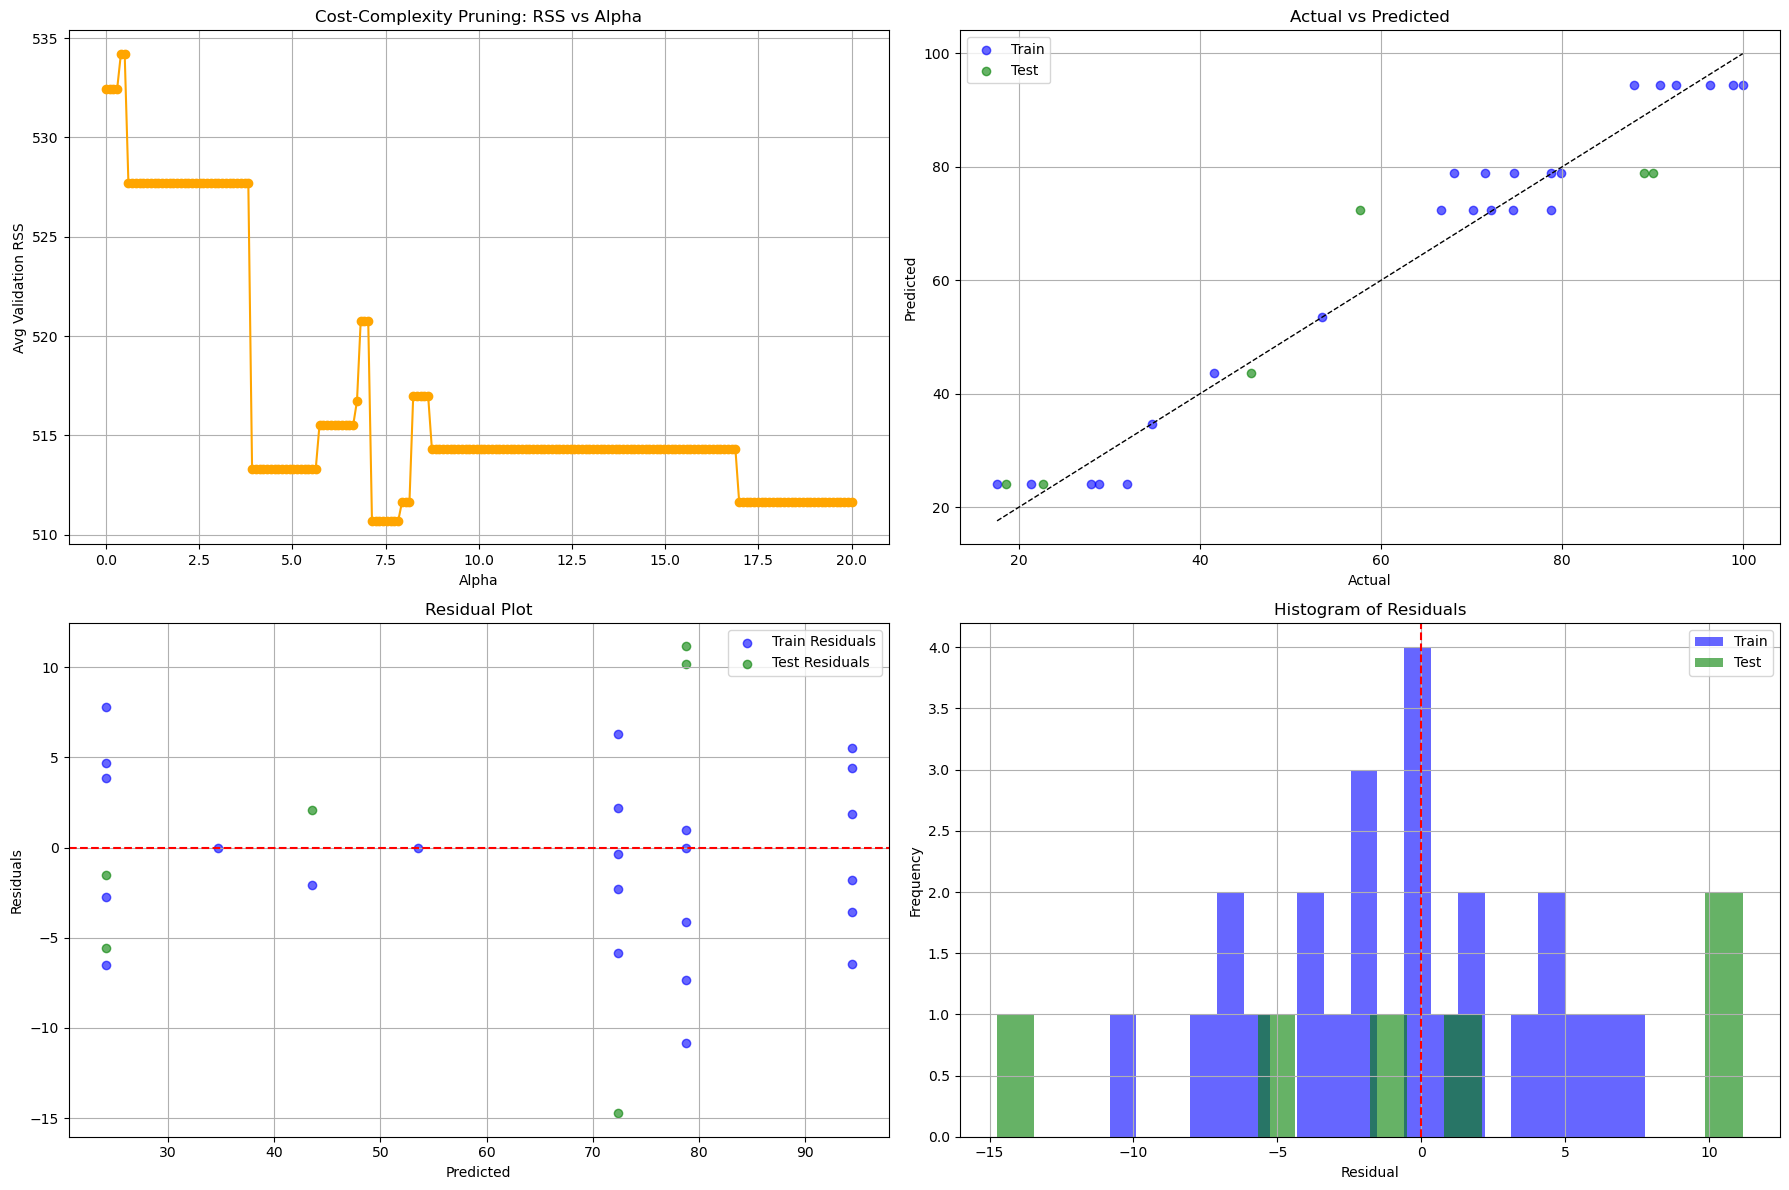

In [3]:

x = income[['Education', 'Seniority']].values
y = income['Income'].values  # convert to numpy array for consistency

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 1: Build full tree
tree = build_tree(x, y)
print(" Full Tree:")
print("────────────────────────────────────")

print_tree(tree)

# Step 2: Select best alpha via CV
alphas = np.linspace(0, 20, 200)
best_alpha, rss_list = select_best_alpha_by_cv(train_x, train_y, alphas)

# Step 3: Prune tree using best alpha
best_tree = get_best_subtree(tree, train_x, train_y, best_alpha)
print(f"\n Best Pruned Tree (alpha = {best_alpha:.4f}):")
print("The best tree is :")
print("────────────────────────────────────")

print_tree(best_tree)


# Step 4: Predictions
# Predictions
train_preds = predict_tree(best_tree, train_x)
test_preds = predict_tree(best_tree, test_x)

# Evaluation
train_mse = mean_squared_error(train_y, train_preds)
test_mse = mean_squared_error(test_y, test_preds)

train_r2 = r2_score_custom(best_tree, train_x, train_y)
test_r2 = r2_score_custom(best_tree, test_x, test_y)


# Output
print("\nFinal Model Evaluation Report")
print("────────────────────────────────────")
print(f'Best Alpha    : {best_alpha:.4f}')
print(f"Train MSE     : {train_mse:.4f}")
print(f"Test MSE      : {test_mse:.4f}")
print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score : {test_r2:.4f}")

plot_all(rss_list,best_tree, train_x, test_x, train_y, test_y, alphas,train_preds, test_preds, max_depth=4)



## Introduction to Random Forest

Random Forest is an ensemble method used for both **classification** and **regression** tasks. It works by building multiple decision trees and combining their outputs to make more accurate and stable predictions.

### Key Concepts

- **Ensemble Learning**: Random Forest combines many decision trees to produce one strong model.
- **Bagging (Bootstrap Aggregation)**: It trains each tree on a different random sample (with replacement) of the data.
- **Feature Randomness**: At each split in a tree, only a random subset of features is considered, which adds more variation and reduces overfitting.

### Working Process

1. Create multiple random subsets of the dataset (with replacement).
2. Train a decision tree on each subset using a random subset of features at each node.
3. For regression, average the predictions of all trees.
4. For classification, use majority voting to decide the final class.

### Advantages

- Reduces overfitting compared to a single decision tree.
- Works well with large datasets and high-dimensional data.
- Handles missing values and maintains accuracy.




## Dataset Summary: Boston Housing Data (for Random Forest & Boosting)

- **Load Data**:  
  `boston = pd.read_csv('Boston.csv')`

- **Clean Data**:  
  Dropped missing rows and `'Unnamed: 0'` column  
  `boston = boston.dropna().drop('Unnamed: 0', axis=1)`

- **Shape**:  
  `boston.shape → (506, 13)`

- **Preview**:  
  `boston.head(5)` — shows first 5 rows

- **Target Variable**:  
  `medv` (Median home value) — regression target

- **Correlation Analysis**:  
  - Strong positive: `rm`  
  - Strong negative: `lstat`, `ptratio`, `indus`  
  - `sns.heatmap(boston.corr(), annot=True)`

- **Feature Selection (for models)**:  
  Use top correlated predictors like `rm`, `lstat`, `ptratio`, etc.

- **Statistical Summary**:  
  `boston.describe()` — for mean, std, min, max, etc.


Index(['Unnamed: 0', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis',
       'rad', 'tax', 'ptratio', 'lstat', 'medv'],
      dtype='object')
(506, 14)
   Unnamed: 0     crim    zn  indus  chas    nox     rm   age     dis  rad  \
0           1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1           2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2           3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3           4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4           5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio  lstat  medv  
0  296     15.3   4.98  24.0  
1  242     17.8   9.14  21.6  
2  242     17.8   4.03  34.7  
3  222     18.7   2.94  33.4  
4  222     18.7   5.33  36.2  
medv       1.000000
rm         0.695360
zn         0.360445
dis        0.249929
chas       0.175260
age       -0.376955
rad       -0.381626
crim      -0.388305
nox       -0.427321
tax 

,Education,Seniority,Income
count,30.000000,30.000000,30.000000
mean,16.386207,93.862069,62.744733
std,3.810622,55.715623,27.013285
min,10.000000,20.000000,17.613593
25%,12.482759,44.827586,36.392043
50%,17.034483,94.482759,70.804791
75%,19.931034,133.275862,85.930608
max,21.586207,187.586207,99.917173


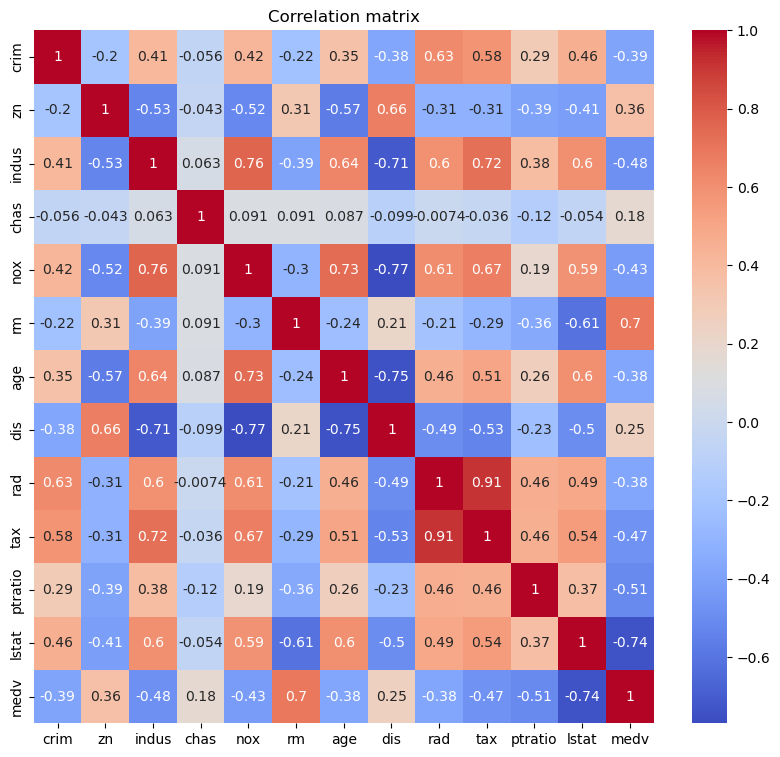

In [4]:
boston = pd.read_csv('Boston.csv')
print(boston.columns)
boston = boston.dropna(axis=0)
print(boston.shape)
print(boston.head(5))
boston = boston.drop('Unnamed: 0', axis=1)


co_rr = boston.corr()
k,l = subplots(figsize = (10,9))
sns.heatmap(co_rr, annot= True, cmap='coolwarm' )
l.set_title('Correlation matrix')

cor = co_rr['medv'].sort_values(ascending= False)
print(cor)

income.describe()


#  Random Forest: Applying Concept

This code demonstrates the **core idea of Random Forest**, built from scratch. Let's break down the process and explain how we apply the Random Forest concept through each step.

---

##  What is Random Forest?

Random Forest is an **ensemble model** made by combining predictions from **multiple decision trees**.  
Each tree:
- Gets trained on a **random subset of data** (bootstrap sampling),
- With a **random subset of features** (feature bagging),
- And the final prediction is an **average of all tree predictions**.

This approach helps:
- Reduce overfitting,
- Improve generalization,
- Increase model stability.

---

##  How We Implement Random Forest (Step-by-Step)

### 1. Random Feature Selection (`def pick_random()`)
- For each tree, we randomly select a subset of features.
- Ensures diversity among trees, a key to Random Forest's power.

### 2. Train/Test Split
- We split the dataset once into training and test sets.

### 3. Ensemble Training Loop
* We loop B times to build B trees. In each iteration:
* Select Random Features (`features = pick_random(X_train.columns.tolist()`)
* Bootstrap Sampling (`tree = build_tree(X_boot.values, y_boot)`)
      - Samples data with replacement to simulate new datasets.
*  Build Decision Tree (`tree = build_tree(X_boot.values, y_boot)`)
      - Each tree is trained on a different subset of data and features.
* Predict on Train/Test Set 

### 4. Average Predictions (Final Random Forest Prediction)
- Random Forest Prediction = Average of all tree predictions.

### 5. Plots
-  Plot 1: MSE per Tree
    * Shows how each tree performs individually.
    * Helps detect variance and overfitting.

- Plot 2: R² per Tree
    * Shows R² score (variance explained) for each tree.
    * A high R² across trees means consistent, good models.

- Plot 3: Histogram of Test R²
    * Distribution of test R² scores from all trees.
    * Helps check stability and spread of tree performance.

## Results:

| Metric         | Value | Meaning                                                         |
| -------------- | ----- | --------------------------------------------------------------- |
| Train MSE      | 11.20 | Small error on training data                                    |
| Test MSE       | 12.33 | Low error on unseen test data                                   |
| Train R² Score | 0.871 | 87.1% variance explained in training set                        |
| Test R² Score  | 0.831 | 83.1% variance explained in test set → **great generalization** |

## Conclusion:
- This code successfully simulates a Random Forest model from scratch.
- Applies both row-wise and column-wise randomness to promote diversity.
- Results are averaged for final prediction.
- Performance is evaluated using MSE, R², and diagnostic plots.


In [5]:



# picking any columns upto n for random forest:
def pick_random(lst):
    random.seed(50)
    k = random.randint(1, len(lst))
    return random.sample(lst, k)

def random_forest(x,y,B):

    # 1️ Fixed final test set (split only once)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # 2️ Ensemble storage
    train_preds_all = []
    test_preds_all = []

    # 3️ Loop to build trees
    for i in range(B):
        # Random subset of features
        features = pick_random(X_train.columns.tolist())  # keep seed outside loop if you want different each time
        X_sub = X_train[features]

        # Bootstrap sampling from training data
        X_boot, y_boot = resample(X_sub, y_train, replace=True, random_state=42 + i)

        # Train tree
        tree = build_tree(X_boot.values, y_boot)

        # Predict on entire training and test set using this tree
        train_preds_all.append(predict_tree(tree, X_sub.values))
        test_preds_all.append(predict_tree(tree, X_test[features].values))

    # 4️ Average ensemble prediction
    train_pred_avg = np.mean(train_preds_all, axis=0)
    test_pred_avg = np.mean(test_preds_all, axis=0)

    train_MSE = mean_squared_error(y_train, train_pred_avg)
    test_MSE = mean_squared_error(y_test, test_pred_avg)
    train_R2 = r2_score(y_train, train_pred_avg)
    test_R2 = r2_score(y_test, test_pred_avg)
    train_R2_all = [r2_score(y_train, pred) for pred in train_preds_all]
    test_R2_all = [r2_score(y_test, pred) for pred in test_preds_all]


    # 5️ Evaluate
    print("Final Train MSE:", train_MSE)
    print("Final Test MSE:", test_MSE)
    print("Final Train R²:", train_R2)
    print("Final Test R²:", test_R2)



    #plots
    # 1. MSE per tree
    train_MSE_all = [mean_squared_error(y_train, pred) for pred in train_preds_all]
    test_MSE_all = [mean_squared_error(y_test, pred) for pred in test_preds_all]

    # . Plot: MSE per tree
    plt.figure(figsize=(10,6))
    plt.plot(range(B), train_MSE_all, label="Train MSE", marker='o', color='blue')
    plt.plot(range(B), test_MSE_all, label="Test MSE", marker='s', color='red')
    plt.xlabel("Tree Number")
    plt.ylabel("Mean Squared Error")
    plt.title("Train vs Test MSE per Tree in Random Forest")
    plt.legend()
    plt.grid(True)
    plt.show()



    #2 Plot: Train vs Test R² Score Over Trees
    plt.figure(figsize=(10,6))
    plt.plot(range(B), train_R2_all, label="Train R²", marker='^', color='green')
    plt.plot(range(B), test_R2_all, label="Test R²", marker='v', color='orange')
    plt.xlabel("Tree Number")
    plt.ylabel("R² Score")
    plt.title("Train vs Test R² per Tree in Random Forest")
    plt.legend()
    plt.grid(True)
    plt.show()


    #3 Plot: Histogram of Test R^2 (to check spread)
    plt.figure(figsize=(8,5))
    plt.hist(test_R2_all, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel("Test R² Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Test R² Scores")
    plt.grid(True)
    plt.show()

    return

- Calling the core function for applying Random Forest code on boston dataset.
- Response variable is `medv`
- Predictor is all rest columns.
- Making `B = 100` parallels decision tree and there average of prediction will final prediction.

Final Train MSE: 11.202275866049131
Final Test MSE: 12.33315851787069
Final Train R²: 0.8710505704647056
Final Test R²: 0.8318215972724626


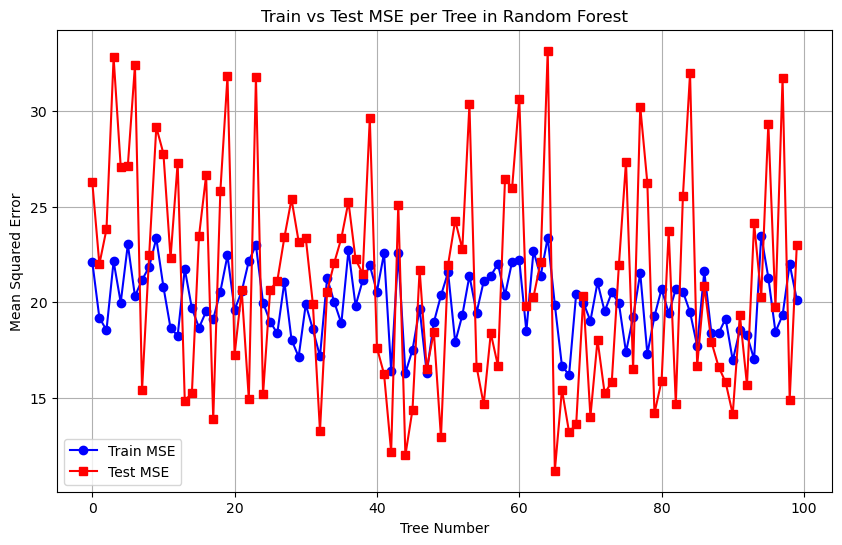

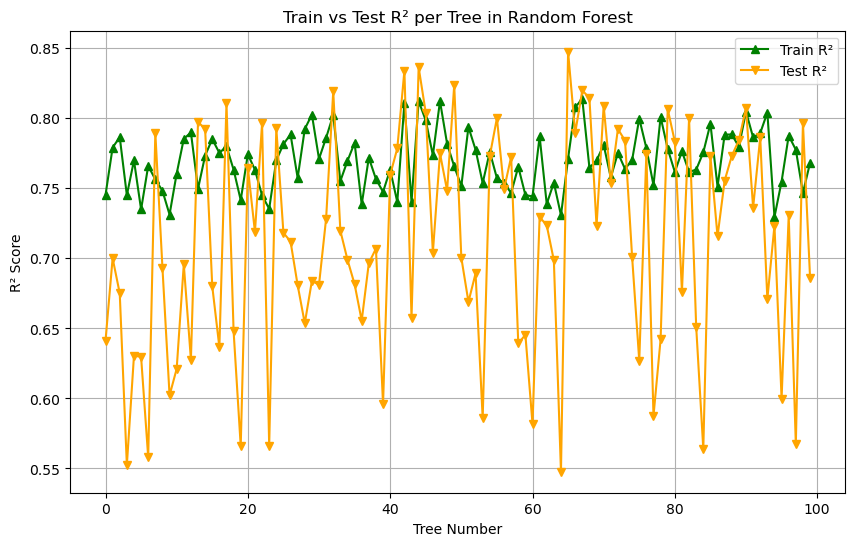

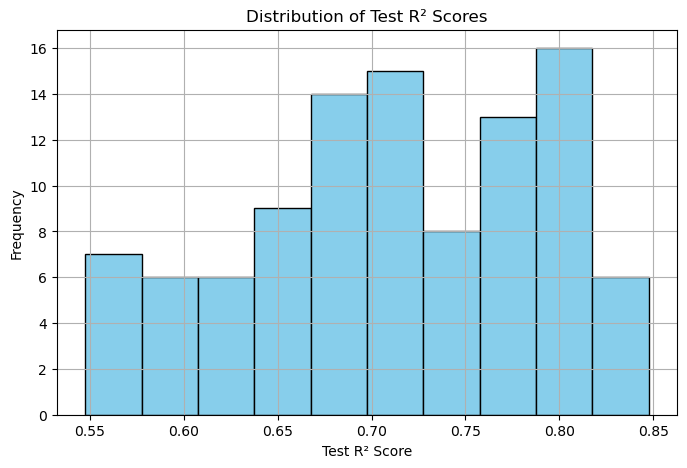

In [6]:

y_r = boston['medv'].values
x_r = boston[['crim', 'zn', 'indus', 'chas', 'nox', 'rm',
              'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']]

random_forest(x_r, y_r, 100)

# Gradient Boosting Implementation

## Objective
We implement a **Gradient Boosting** model from scratch for regression (like XGBoost), where:
- Each tree learns from the **errors (residuals)** of the previous trees.
- We update the model gradually using a **learning rate**.
- Final prediction is a **weighted sum** of weak learners (shallow trees).

---

##  Boosting: Key Concepts Used

| Concept                         | Implementation Details                                                  |
|---------------------------------|---------------------------------------------------------------------------|
| Additive Modeling               | Trees are added sequentially to fix errors.                              |
| Gradient Descent on Loss        | Residuals act as negative gradient of squared error loss.                |
| Learning Rate                   | `y_pred += learning_rate * tree_output` controls update speed.           |
| Residuals Update                | `residual -= learning_rate * pred_train` after each tree.                |
| Model Evaluation                | Done via **MSE**, **R²**, and various performance plots.                 |

---

##  Step-by-Step Explanation of Code

### 1. Initialization
- Start with prediction = 0
- Initial residual = actual values

### 2. Iterative Tree Building
- Train a decision tree to predict residuals (errors).
- This tree learns how to correct the previous prediction.

### 3. Prediction Update
- Update the model by adding this tree's prediction.
- Subtract it from residuals to minimize future error.
- Controlled via learning rate.

### 4. Metric Tracking
- We store the MSE and R² for every boosting step.
- This lets us see how the model improves over iterations.


 ## Visualization & Plot Interpretation
1. **Train vs Test R² per Iteration**
- Shows how the model improves with each added tree.

If test R² plateaus or drops, model might be overfitting.

2. **Train vs Test MSE per Iteration**
    - Steady drop in MSE = good learning.
    - If test MSE increases = model is learning noise.

3. **Actual vs Predicted Plot**
    - Diagonal line = perfect predictions.
    - Closer the points to line → better.

4. **Residual Plot**
    - Scatter of residuals vs predictions.
    - Should be centered around 0. No clear pattern = good model.

5. **Histogram of Test R²**
    - Distribution of model performance across boosting rounds.
    - Helps understand stability and spread of test R² scores.

## Results:
|Matric | Value|
--------|----------
|No. of trees| 500|
|Learning rate| 0.01|
|Final Train MSE| 3.83|
|Final Test MSE|7.81|
|Final Train R²| 0.955|
|Final Test R²| 0.893|

## Summary
- Boosting improves model by sequentially fixing previous errors.
- Learning rate prevents overshooting, enabling gradual learning.
- Visualization helps verify model health and generalization.
- This XGBoost-like model works great for tabular regression tasks.


In [7]:


# 2️ Boosting Function
def boosting(X_train, y_train, X_test,y_test, n_estimators, learning_rate):
    models = []
    train_preds_all = []
    test_preds_all = []

    # Step 1: Initialize predictions to 0
    y_pred_train = np.zeros_like(y_train)
    y_pred_test = np.zeros(len(X_test))

    # Step 2: Initialize residuals
    residual = y_train.copy()
    
    train_MSE_list = []
    test_MSE_list = []
    train_R2_list = []
    test_R2_list = []


    for i in range(n_estimators):
        # 2(a): Fit tree on residuals
        tree = build_tree(X_train.values, residual)

        # Predict current tree output
        pred_train = predict_tree(tree, X_train.values)
        pred_test = predict_tree(tree, X_test.values)

        # 2(b): Update predictions
        y_pred_train += learning_rate * pred_train
        y_pred_test += learning_rate * pred_test

        # 2(c): Update residuals
        residual -= learning_rate * pred_train

        # Save current predictions
        train_preds_all.append(np.copy(y_pred_train))
        test_preds_all.append(np.copy(y_pred_test))

        models.append(tree)
        train_MSE_list.append(mean_squared_error(y_train, y_pred_train))
        test_MSE_list.append(mean_squared_error(y_test, y_pred_test))

        train_R2_list.append(r2_score(y_train, y_pred_train))
        test_R2_list.append(r2_score(y_test, y_pred_test))
        
    # 4️ Evaluate final predictions
    train_pred_final = train_preds_all[-1]
    test_pred_final = test_preds_all[-1]


    train_MSE = mean_squared_error(y_train, train_pred_final)
    test_MSE = mean_squared_error(y_test, test_pred_final)
    train_R2 = r2_score(y_train, train_pred_final)
    test_R2 = r2_score(y_test, test_pred_final)

    print(" Final Train MSE:", train_MSE)
    print(" Final Test MSE:", test_MSE)
    print(" Final Train R²:", train_R2)
    print(" Final Test R²:", test_R2)

    # 1️ R² per iteration
    plt.figure(figsize=(10, 5))
    plt.plot(train_R2_list, label="Train R²", color='blue')
    plt.plot(test_R2_list, label="Test R²", color='red')
    plt.xlabel("Boosting Iteration")
    plt.ylabel("R² Score")
    plt.title("Train vs Test R² over Boosting Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2 MSE per iteration
    plt.figure(figsize=(10, 5))
    plt.plot(train_MSE_list, label="Train MSE", color='blue')
    plt.plot(test_MSE_list, label="Test MSE", color='red')
    plt.xlabel("Boosting Iteration")
    plt.ylabel("Mean Squared Error")
    plt.title("Train vs Test MSE over Boosting Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3️ Actual vs Predicted (Final model)
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, test_pred_final, alpha=0.7, color='purple')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
    plt.xlabel("Actual MEDV")
    plt.ylabel("Predicted MEDV")
    plt.title("Actual vs Predicted MEDV (Test Set)")
    plt.grid(True)
    plt.show()

    # 4️ Residual Plot 
    final_residuals = y_test - test_pred_final
    plt.figure(figsize=(10, 5))
    plt.scatter(test_pred_final, final_residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted MEDV")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()
    
    
    
    #5 Plot: Histogram of Test R^2 (to check spread)
    plt.figure(figsize=(10,5))
    plt.hist(test_R2_list, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel("Test R² Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Test R² Scores")
    plt.grid(True)
    plt.show()
    return 




 Final Train MSE: 3.832853842334003
 Final Test MSE: 7.811434746442916
 Final Train R²: 0.9558800084580096
 Final Test R²: 0.8934810886632497


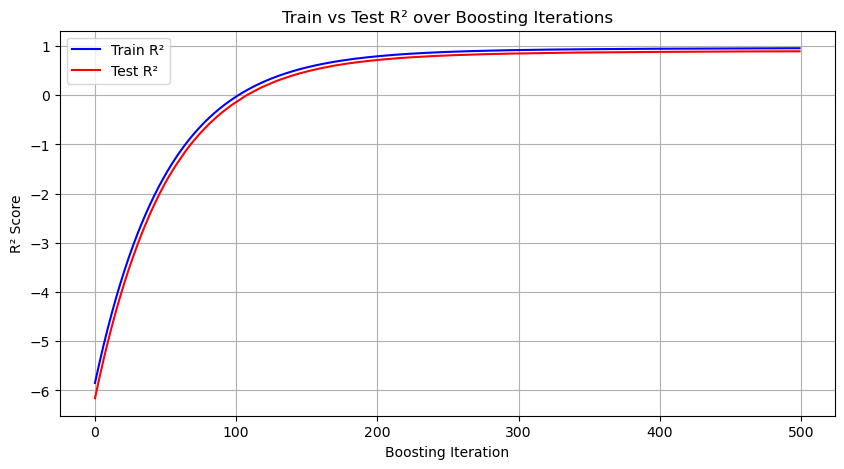

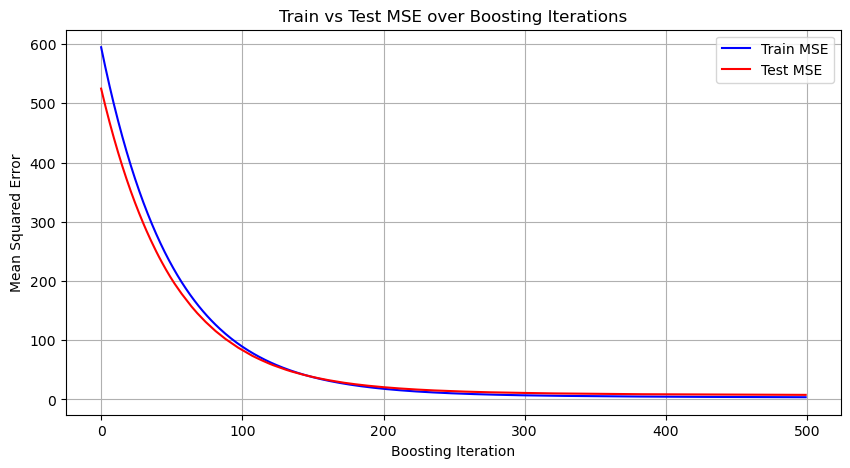

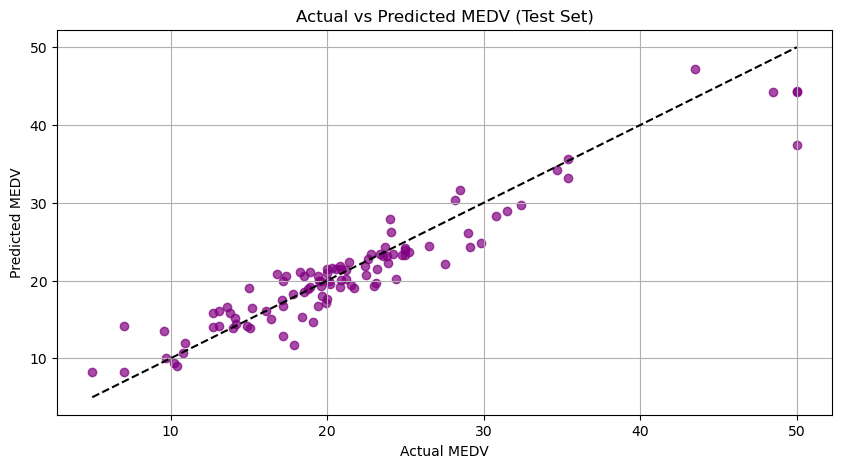

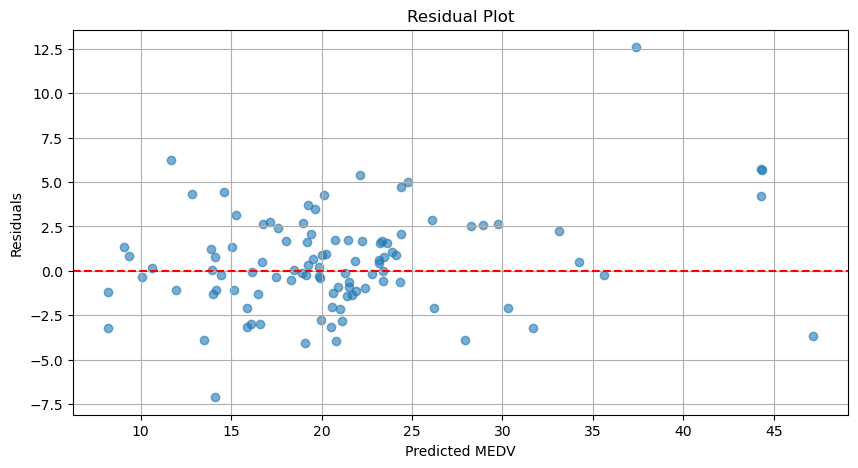

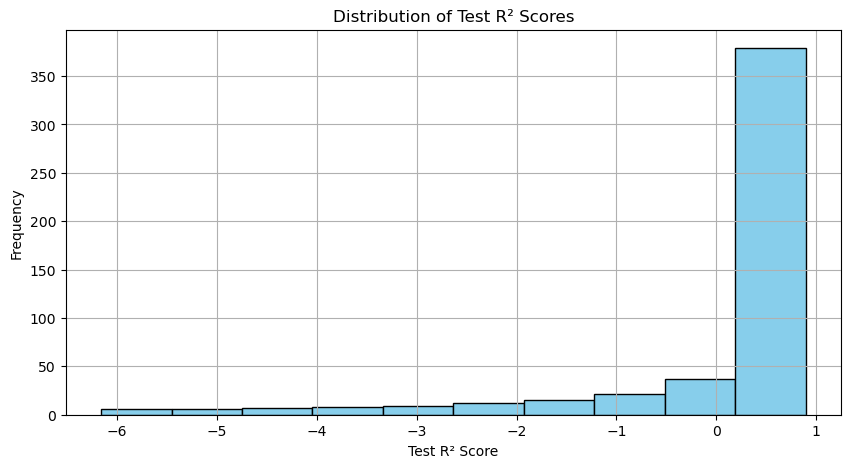

In [8]:
columns = boston.columns

y_b = boston['medv'].values
x_b = boston[['crim', 'zn', 'indus', 'chas', 'nox', 'rm',
              'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']]

# Fixed test split
X_train, X_test, y_train, y_test = train_test_split(x_b, y_b, test_size=0.2, random_state=42)

boosting(X_train, y_train, X_test,y_test, n_estimators = 500, learning_rate = 0.01)

#  Random Forest vs Boosting: Performance Comparison

## What This Code Does

This bar chart compares **Random Forest** and **Boosting** using 4 key metrics:

- **Final Train MSE**
- **Final Test MSE**
- **Final Train R²**
- **Final Test R²**

Each metric has two bars:
-  Random Forest (Sky Blue)
-  Boosting (Orange)

---

##  Plot Insights

| Metric             | Random Forest | Boosting   | Better Model     |
|--------------------|---------------|------------|------------------|
| Train MSE          | 11.20         | **3.83**   | Boosting      |
| Test MSE           | 12.33         | **7.81**   | Boosting      |
| Train R²           | 0.87          | **0.955**  |  Boosting      |
| Test R²            | 0.83          | **0.893**  |  Boosting      |

---

##  Interpretation

-  **Lower MSE**: Boosting has smaller errors in both train and test sets.
- **Higher R²**: Boosting explains more variance in target values.

>  Boosting clearly outperforms Random Forest in this setup!



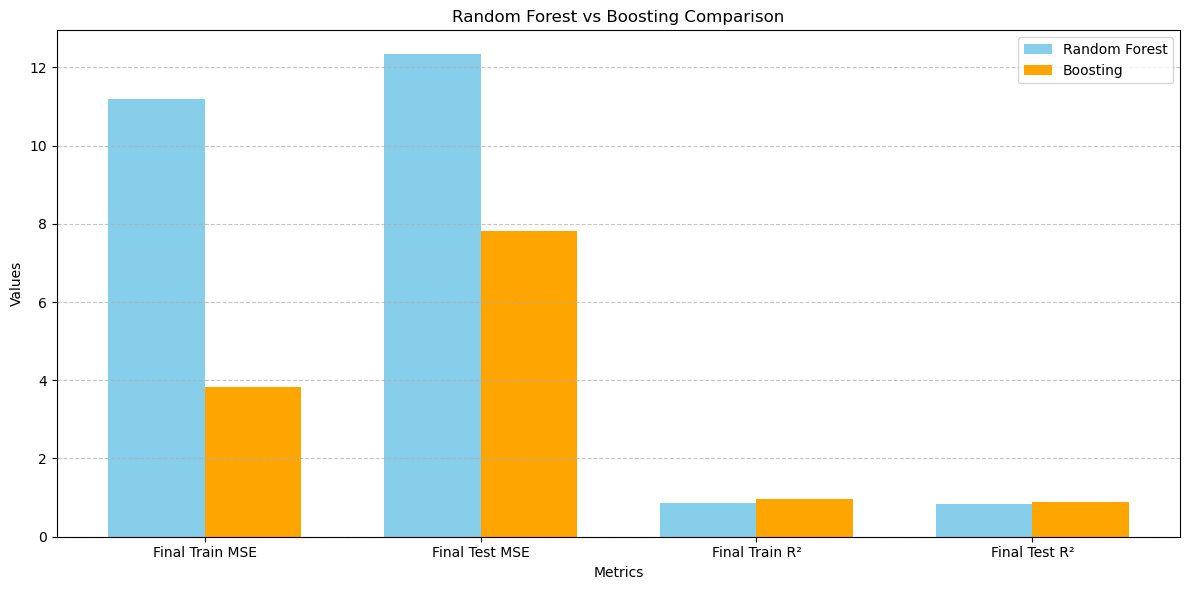

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Sample metrics for comparison (for illustration)
metrics = {
    'Final Train MSE': [11.20, 3.83],
    'Final Test MSE': [12.33, 7.81],
    'Final Train R²': [0.87, 0.955],
    'Final Test R²': [0.83, 0.893]
}

models = ['Random Forest', 'Boosting']
bar_width = 0.35
index = np.arange(len(metrics))

# Create plots for comparison
fig, ax = plt.subplots(figsize=(12, 6))

for i, (metric, values) in enumerate(metrics.items()):
    bar1 = ax.bar(index[i] - bar_width/2, values[0], bar_width, label='Random Forest' if i == 0 else "", color='skyblue')
    bar2 = ax.bar(index[i] + bar_width/2, values[1], bar_width, label='Boosting' if i == 0 else "", color='orange')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Random Forest vs Boosting Comparison')
ax.set_xticks(index)
ax.set_xticklabels(metrics.keys())
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Random Forest vs Boosting 

###  Random Forest
- **Type**: Bagging ensemble method
- **Working**: Builds multiple decision trees using bootstrapped samples and averages their predictions.
- **Goal**: Reduce variance (overfitting).
- **Key Traits**:
  - Trees are grown in parallel.
  - Feature selection at each split (random subset).
  - Robust to noise, less prone to overfitting.
- **Use Case**: When accuracy and stability are both important.

###  Boosting (e.g., AdaBoost, Gradient Boosting)
- **Type**: Sequential ensemble method
- **Working**: Builds trees sequentially, each correcting errors from the previous one.
- **Goal**: Reduce bias (underfitting).
- **Key Traits**:
  - Trees are shallow (weak learners).
  - Focuses more on misclassified points.
  - Higher accuracy but more prone to overfitting without tuning.
- **Use Case**: When model interpretability is less important, and accuracy is the priority.


##  Plot Explanation – What Each Graph Tells Us

### 1️. **MSE per Tree / Boosting Iteration**
- **Purpose**: Measures how the error (Mean Squared Error) changes as more trees are added.
- **Interpretation**:
  - In **Random Forest**, MSE stays relatively stable as trees are trained independently.
  - In **Boosting**, MSE steadily decreases as each tree corrects the previous one.
- **Goal**: Lower MSE = Better model fit.

### 2️. **R² Score per Tree / Iteration**
- **Purpose**: Shows how well the model explains the variance in the target variable.
- **Interpretation**:
  - Higher R² = Better predictions.
  - Boosting often shows rapid R² improvement across iterations.
- **Train vs Test R²**: Helps detect overfitting (large gap means overfit).

### 3️. **Actual vs Predicted Plot**
- **Purpose**: Compares predicted values with actual values on the test set.
- **Interpretation**:
  - Points close to the diagonal line = accurate predictions.
  - Large deviations = poor model fit.

### 4️. **Residual Plot**
- **Purpose**: Plots residuals (errors) vs predicted values.
- **Ideal Case**: Residuals should be randomly scattered around 0 (no pattern).
- **Pattern in Residuals**: Suggests the model might be missing some structure in the data.

### 5️. **Histogram of Test R²**
- **Purpose**: Distribution of performance across all trees (in RF) or iterations (in Boosting).
- **Interpretation**:
  - Sharp peak = consistent performance.
  - Wide spread = unstable prediction quality across trees.

---

##  Final Results Summary (Example Output)

| Metric             | Random Forest        | Boosting               |
|--------------------|----------------------|------------------------|
| **Final Train MSE** | 11.20                | 3.83                   |
| **Final Test MSE**  | 12.33                | 7.81                  |
| **Final Train R²**  | 0.871                | 0.955                  |
| **Final Test R²**   | 0.831                | 0.893                  |

 **Boosting wins** in accuracy but is more prone to overfitting.  
 **Random Forest** is more stable and better for quick deployment.

---

##  Conceptual Comparison Table

| Feature                    | Random Forest                                     | Boosting (Gradient Boosting)                          |
|---------------------------|---------------------------------------------------|--------------------------------------------------------|
| **Core Idea**              | Multiple independent trees                        | Sequential trees, each correcting errors               |
| **Ensemble Type**          | Bagging (parallel)                                | Boosting (sequential)                                 |
| **Tree Building**          | Independently on random subsets                   | Each on residuals of previous tree                    |
| **Feature Selection**      | Random subset of features                         | All features (or subset via regularization)           |
| **Bias-Variance**          | Low variance, higher bias                         | Low bias, can overfit if not tuned                    |
| **Outlier Handling**       | Robust to outliers                                | Sensitive to outliers                                 |
| **Speed**                  | Faster (parallelizable)                           | Slower (sequential)                                   |
| **Tuning Complexity**      | Low – works well out-of-the-box                   | Needs learning rate, n_estimators tuning              |
| **Overfitting Risk**       | Lower                                             | Higher (needs regularization like shrinkage)          |
| **Interpretability**       | Hard to interpret many trees                      | Slightly better if using few estimators               |

---

##  When to Use What?

| Scenario                                  | Use Random Forest                     | Use Boosting                            |
|------------------------------------------|---------------------------------------|------------------------------------------|
| Want fast training & easy tuning         | Yes                                     | No                                        |
| High accuracy is more important          | No                                    | Yes                                      |
| Data is noisy or has many outliers       | Yes                                    | No                                        |
| You want interpretability with fewer trees| No                                     | Yes (to some extent)                      |
| You care about generalization            | Yes                                    | Yes (if tuned well)                       |
| Limited compute power                    | Yes                                     | No                                        |

---

##  Final Summary

- **Random Forest** is great when you need a strong, stable model with less risk of overfitting and minimal tuning.
- **Boosting** is powerful for squeezing out the last bits of accuracy, especially on clean datasets, but demands more care with tuning to avoid overfitting.


